In [128]:
import pyspark
from pyspark.sql import *
import pyspark.sql.functions as f

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType, StructType

import matplotlib.pyplot as plt

In [129]:
# Configuração

spark = SparkSession \
    .builder \
    .master("local[8]") \
    .appName("tp_final_jean_luiz").getOrCreate()

df1Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat", "double") \
    .add("long", "double") \
    .add("timestamp", "timestamp") \
    .add("pressure", "double") \
    .add("temperature", "double") \
    .add("humidity", "double") \

df2Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat", "double") \
    .add("long", "double") \
    .add("timestamp", "timestamp") \
    .add("P1", "double") \
    .add("P2", "double") \

df1 = spark.read.schema(df1Schema).format("csv").load("/home/luiz/SofiaAirQuality/OneMonthBme", header=True)
df2 = spark.read.schema(df2Schema).format("csv").load("/home/luiz/SofiaAirQuality/OneMonthSds", header=True)

In [131]:
df1 = df1 \
    .withColumn("df1Location", df1.location) \
    .withColumn("df1Timestamp", df1.timestamp) \
    .withColumn("df1Id", df1.sensor_id).limit(5000)

df2 = df2 \
    .withColumn("df2Location", df2.location) \
    .withColumn("df2Timestamp", df2.timestamp) \
    .withColumn("df2Id", df2.sensor_id).limit(5000)

In [132]:
df1.count()

701548

In [133]:
df2.count()

1049187

In [134]:
joined = df1.join(
  df2,
  f.expr("""
    df1Location = df2Location AND
    df1Timestamp <= df2Timestamp + interval 1 minutes AND
    df1Timestamp >= df2Timestamp - interval 1 minutes
    """)
)

In [135]:
joined.count()

681270

In [136]:
# TODO talvez tenha um jeito melhor de fazer isso

joinedWithoutDuplicates = joined.dropDuplicates(['df1Id', 'df1Timestamp'])

In [137]:
joinedWithoutDuplicates.count()

681251

In [115]:
columnsOfInterest = ['df1Id', 'df1Timestamp', 'df1Location', 'df2Id', 'df2Timestamp', 'df2Location', 'pressure', 'temperature', 'humidity', 'P1', 'P2']
joinedWithoutDuplicates.filter(joinedWithoutDuplicates.df1Id == 2266).select(*columnsOfInterest).show(100)

+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
|df1Id|       df1Timestamp|df1Location|df2Id|       df2Timestamp|df2Location|pressure|temperature|humidity|   P1|   P2|
+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
| 2266|2017-07-01 00:00:07|       1140| 2265|2017-07-01 00:00:06|       1140|95270.27|      23.46|   62.48|25.33| 6.57|
| 2266|2017-07-01 00:02:33|       1140| 2265|2017-07-01 00:02:33|       1140|95266.66|      23.37|    63.4| 15.7| 6.27|
| 2266|2017-07-01 00:05:00|       1140| 2265|2017-07-01 00:04:59|       1140|95258.14|      23.37|   63.22|18.17|  6.6|
| 2266|2017-07-01 00:07:26|       1140| 2265|2017-07-01 00:07:26|       1140|95267.81|      23.23|   63.07| 15.9| 6.83|
| 2266|2017-07-01 00:09:53|       1140| 2265|2017-07-01 00:09:52|       1140|95267.84|      23.25|   63.37|13.67| 5.97|
| 2266|2017-07-01 00:12:19|       1140| 

In [138]:
tmpp = joinedWithoutDuplicates \
    .withColumn("timestampDelta", joinedWithoutDuplicates.df2Timestamp.cast("long") - joinedWithoutDuplicates.df1Timestamp.cast("long")) \
    .withColumn("idDifference", joinedWithoutDuplicates.df2Id - joinedWithoutDuplicates.df1Id)

tmpp \
    .select("timestampDelta") \
    .agg(f.avg("timestampDelta")) \
    .show()

tmpp \
    .agg(f.avg("idDifference")) \
    .show()

+-------------------+
|avg(timestampDelta)|
+-------------------+
|-0.6711300240293225|
+-------------------+



+-----------------+
|avg(idDifference)|
+-----------------+
|             -1.0|
+-----------------+



In [117]:
columnsOfInterest = ['df1Id', 'df1Timestamp', 'df1Location', 'df2Id', 'df2Timestamp', 'df2Location', 'pressure', 'temperature', 'humidity', 'P1', 'P2']
joinedWithoutDuplicates.select(*columnsOfInterest).show(100)

+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
|df1Id|       df1Timestamp|df1Location|df2Id|       df2Timestamp|df2Location|pressure|temperature|humidity|   P1|   P2|
+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
| 2266|2017-07-01 00:00:07|       1140| 2265|2017-07-01 00:00:06|       1140|95270.27|      23.46|   62.48|25.33| 6.57|
| 2292|2017-07-01 00:00:08|       1154| 2291|2017-07-01 00:00:07|       1154|94355.83|      23.06|   59.46|15.07| 9.67|
| 3096|2017-07-01 00:00:10|       1558| 3095|2017-07-01 00:00:10|       1558|95155.81|      26.53|   44.38| 15.6| 6.43|
| 3428|2017-07-01 00:00:12|       1727| 3427|2017-07-01 00:00:12|       1727|94679.57|      28.34|   38.28|13.73| 6.43|
| 3472|2017-07-01 00:00:13|       1750| 3471|2017-07-01 00:00:12|       1750|94327.88|      26.31|   46.37| 20.9|10.67|
| 1952|2017-07-01 00:00:13|        976| 

/tmp/ipykernel_12575/3441399253.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
/tmp/ipykernel_12575/3441399253.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


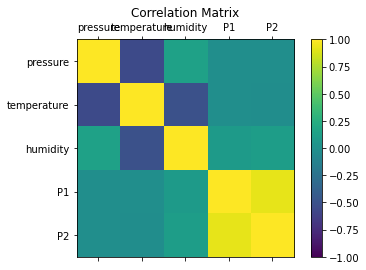

+--------------------+--------------------+-------------------+--------------------+--------------------+
|            pressure|         temperature|           humidity|                  P1|                  P2|
+--------------------+--------------------+-------------------+--------------------+--------------------+
|                 1.0| -0.5490584285915046|0.14584096639005958|-0.01359012529365...|-0.01184343938893...|
| -0.5490584285915046|                 1.0|-0.5047419559843607|-0.01032917148332...|-0.01961889933191...|
| 0.14584096639005958| -0.5047419559843607|                1.0| 0.09064557933927937| 0.11572196411973415|
|-0.01359012529365...|-0.01032917148332...|0.09064557933927937|                 1.0|  0.9226479846641606|
|-0.01184343938893...|-0.01961889933191...|0.11572196411973415|  0.9226479846641606|                 1.0|
+--------------------+--------------------+-------------------+--------------------+--------------------+



In [139]:
# 1. Realizar uma análise da correlação entre os atributos presentes na base de dados 
# (pressão, temperatura, umidade, P1 (PM10) e P2 (PM2,5)).

# Filtrando apenas as colunas desejadas
columns = ['pressure','temperature','humidity', 'P1', 'P2'] # faltando P1 e P2 no dataframe 
df_filtered = joinedWithoutDuplicates.select(*columns)
df_filtered = df_filtered.filter(df_filtered.pressure.isNotNull())
df_filtered = df_filtered.filter(df_filtered.temperature.isNotNull())
df_filtered = df_filtered.filter(df_filtered.humidity.isNotNull())

# Criando coluna de vector
vector_column = "vector_column"
assembler = VectorAssembler(inputCols=df_filtered.columns, outputCol=vector_column)
df_vector = assembler.transform(df_filtered).select(vector_column)

# Obtendo matriz de correlação
matrix = Correlation.corr(df_vector, vector_column).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

# Plotando
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
plot_corr_matrix(corrmatrix, columns, 234)

spark.createDataFrame(corrmatrix,columns).show() # testando

In [143]:
spark.createDataFrame(corrmatrix,columns).write.csv('correlation.csv', header=True)